
**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [3]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

**Set Arguments**

In [1]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

# LR = 1e-3          # The initial Learning Rate
LR = 5e-3            

MOMENTUM = 0.9       # Hyperparameter for SGD, kept this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, kept this at the default

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 6        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

PRETRAINED = True
FREEZE_LAYERS = 1    # 0: Don't freeze, 1: freeze conv. layers, 2: freeze FC 
EVAL_MODEL_AFTER_EACH_EPOCH = True
EVAL_ACCURACY_ON_TRAINING = True

**Define Data Preprocessing**

In [4]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

**Caltech Dataset**

In [4]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 17.62 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.


In [5]:
DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
limit = len(train_dataset)

#Split train into train and validation
train_indexes, val_indexes, y_train, y_val = train_test_split([i for i in range(len(train_dataset))], \
                                                              [item[1] for item in train_dataset.data], \
                                                              test_size=0.5, \
                                                              stratify=[item[1] for item in train_dataset.data])
val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

opening: Caltech101/train.txt
opening: Caltech101/test.txt
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


**Prepare Dataloaders**

In [6]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Prepare Network**

In [7]:
if PRETRAINED == False:
  net = alexnet(pretrained=False) # Loading AlexNet model
else:
  net = alexnet(pretrained=True)

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

**Prepare Training**

In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy
criterion_val = nn.CrossEntropyLoss(reduction='sum')

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
if FREEZE_LAYERS == 0:
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif FREEZE_LAYERS == 1: # Freeze Conv. layers
  parameters_to_optimize = net.classifier.parameters() # Only update FC layers parameters
elif FREEZE_LAYERS == 2: # Freeze FC layers
  parameters_to_optimize = net.features.parameters() # Only update conv. layers parameters
else:
  print('Fatal error: wrong setting in FREEZE_LAYERS')
  exit()

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [10]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
losses_train = []
losses_val = []
accuracies_val = []
accuracies_train = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    if current_step == 0:
      print('--- Initial loss on train: {}'.format(loss.item()))

    # Log loss
    #if current_step % LOG_FREQUENCY == 0:
    #  print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1
  
  #End of one epoch
  print('--- Epoch {}, Loss on train: {}'.format(epoch+1, loss.item()))
  losses_train.append(loss.item())  #add loss to a list to print it later

  if EVAL_MODEL_AFTER_EACH_EPOCH:
    #evaluate temporary model on validation set (after each epoch has finished)
    net.train(False)

    running_corrects_val = 0
    cum_loss_val = 0

    for images_val, labels_val in tqdm(val_dataloader):
      images_val = images_val.to(DEVICE)
      labels_val = labels_val.to(DEVICE)

      # Forward Pass
      outputs_val = net(images_val)
      cum_loss_val += criterion_val(outputs_val, labels_val).item()

      # Get predictions
      _, preds = torch.max(outputs_val.data, 1)

      # Update Corrects
      running_corrects_val += torch.sum(preds == labels_val.data).data.item()
    
    #Calculate Accuracy
    accuracy_val = running_corrects_val / float(len(val_dataset))
    loss_val = cum_loss_val / float(len(val_dataset))

    losses_val.append(loss_val)
    accuracies_val.append(accuracy_val)
    
    print('\n')
    print('Loss on val:', loss_val)
    print('Accuracy on val:', accuracy_val)

  if EVAL_ACCURACY_ON_TRAINING:
    #evaluate temporary model on training set (accuracy only, loss has already been computed)
    net.train(False)

    running_corrects_train = 0

    for images_train, labels_train in tqdm(train_dataloader):
      images_train = images_train.to(DEVICE)
      labels_train = labels_train.to(DEVICE)

      # Forward Pass
      outputs_train = net(images_train)

      # Get predictions
      _, preds = torch.max(outputs_train.data, 1)

      # Update Corrects
      running_corrects_train += torch.sum(preds == labels_train.data).data.item()
    
    #Calculate Accuracy
    accuracy_train = running_corrects_train / float(len(train_dataset))

    accuracies_train.append(accuracy_train)
    
    print('\n')
    print('Accuracy on training:', accuracy_train)

      

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/10, LR = [0.005]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


--- Initial loss on train: 4.714207649230957
--- Epoch 1, Loss on train: 2.4577836990356445


100%|██████████| 12/12 [00:10<00:00,  1.12it/s]




Loss on val: 2.1720226335327655
Accuracy on val: 0.5200553250345782


100%|██████████| 11/11 [00:08<00:00,  1.35it/s]



Accuracy on training: 0.5421853388658368
Starting epoch 2/10, LR = [0.005]


--- Epoch 2, Loss on train: 1.1376277208328247


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]




Loss on val: 1.2513723122793279
Accuracy on val: 0.6981327800829875


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.7755878284923928
Starting epoch 3/10, LR = [0.005]
--- Epoch 3, Loss on train: 0.6785359382629395


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]




Loss on val: 0.8976140820304058
Accuracy on val: 0.7721300138312587


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]



Accuracy on training: 0.8682572614107884
Starting epoch 4/10, LR = [0.005]


--- Epoch 4, Loss on train: 0.4630599021911621


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]




Loss on val: 0.7368781062082631
Accuracy on val: 0.80567081604426


100%|██████████| 11/11 [00:08<00:00,  1.35it/s]




Accuracy on training: 0.9104426002766252
Starting epoch 5/10, LR = [0.005]
--- Epoch 5, Loss on train: 0.26791414618492126


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]




Loss on val: 0.6886670335529586
Accuracy on val: 0.8156984785615491


100%|██████████| 11/11 [00:09<00:00,  1.20it/s]




Accuracy on training: 0.9336099585062241
Starting epoch 6/10, LR = [0.005]
--- Epoch 6, Loss on train: 0.21747617423534393


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]




Loss on val: 0.6454059513772672
Accuracy on val: 0.8284923928077456


100%|██████████| 11/11 [00:08<00:00,  1.29it/s]




Accuracy on training: 0.9540110650069157
Starting epoch 7/10, LR = [5e-05]
--- Epoch 7, Loss on train: 0.16109393537044525


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]




Loss on val: 0.6422528007053571
Accuracy on val: 0.8298755186721992


100%|██████████| 11/11 [00:09<00:00,  1.17it/s]




Accuracy on training: 0.9543568464730291
Starting epoch 8/10, LR = [0.0005]
--- Epoch 8, Loss on train: 0.25880861282348633


100%|██████████| 12/12 [00:08<00:00,  1.38it/s]




Loss on val: 0.6405545125198892
Accuracy on val: 0.8319502074688797


100%|██████████| 11/11 [00:07<00:00,  1.38it/s]



Accuracy on training: 0.956777316735823
Starting epoch 9/10, LR = [0.0005]


--- Epoch 9, Loss on train: 0.20534178614616394


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]




Loss on val: 0.6378585359037829
Accuracy on val: 0.8298755186721992


100%|██████████| 11/11 [00:09<00:00,  1.16it/s]




Accuracy on training: 0.9581604426002767
Starting epoch 10/10, LR = [0.0005]
--- Epoch 10, Loss on train: 0.26708677411079407


100%|██████████| 12/12 [00:08<00:00,  1.42it/s]




Loss on val: 0.6369730169842353
Accuracy on val: 0.8284923928077456


100%|██████████| 11/11 [00:08<00:00,  1.34it/s]




Accuracy on training: 0.9595435684647303


**Plot Results After Training**

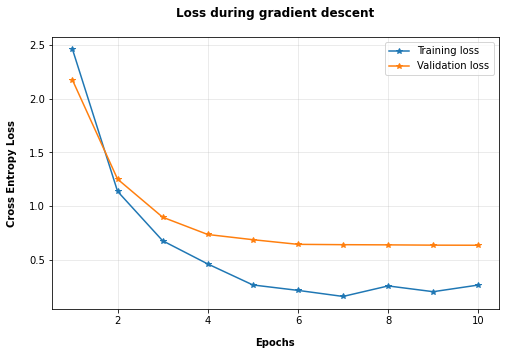

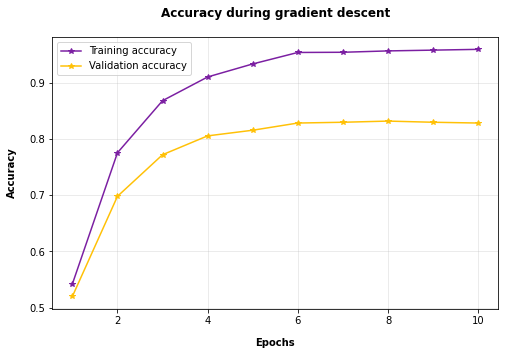

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax.plot(epochs, losses_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, losses_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot accuracies

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, NUM_EPOCHS+1)]
ax.plot(epochs, accuracies_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, accuracies_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

**Validation**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:08<00:00,  1.41it/s]

Validation Accuracy: 0.8284923928077456


**Test**

In [13]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:09<00:00,  1.30it/s]

Test Accuracy: 0.8309713100587626
